In [1]:
%load_ext autoreload
%autoreload 2

%pip install neptune.tensorflow.keras
%pip install transformers

from google.colab import drive, auth
drive.mount('/content/drive', force_remount=True)
auth.authenticate_user()

import numpy as np
import pandas as pd
import neptune.new as neptune

from tqdm.auto import tqdm
from bisect import bisect

import tensorflow as tf
tf.config.optimizer.set_jit(True)

from tensorflow.keras.utils import plot_model
from transformers import TFDistilBertModel, DistilBertTokenizerFast
from transformers import TFBertModel, BertTokenizer
from transformers import TFBartModel, BartTokenizerFast
from transformers import TFRobertaModel, RobertaTokenizer
from transformers import TFT5Model
from transformers import AdamWeightDecay

from glob import glob
from pathlib import Path

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ML Projects/Google AI4Code/modules')
import pipeline, tfmodels, protobuf_handler, valid_analysis, apitokens

print('Libraries Imported')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 318 kB 6.7 MB/s 
     |████████████████████████████████| 829 kB 67.9 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 181 kB 79.6 MB/s 
     |████████████████████████████████| 132 kB 70.3 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 9.0 MB 71.3 MB/s 
     |████████████████████████████████| 79 kB 9.3 MB/s 
     |████████████████████████████████| 139 kB 83.4 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 127 kB 77.9 MB/s 
     |████████████████████████████████| 67 kB 5.7 MB/s 
     |████████████████████████████████| 130 kB 88.4 MB/s 
     |████████████████████████████████| 81 kB 8.1 MB/s 
     |████████████████████████████████| 80 kB 10.7 MB/s 
     |████████████████████████████████| 80 kB

In [2]:
# Initialize TPU Strategy
tpu_strategy = pipeline.check_for_tpu_status()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.109.237.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.109.237.82:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU Strategy has been initialized and setup


In [5]:
# Model Selection
md_trans_model = 'multi'
quad_trans_model = 'cbert'

model_name = 'multi_cbert_md_code_rep'
model_objective = 'md_code_rep'

model_selection = {'quad_search': [protobuf_handler.decode_protobuf,
                                   protobuf_handler.parse_quad_tensor_arrays,
                                   tf.keras.losses.CategoricalCrossentropy,
                                   'val_accuracy', ['<c>']],
                   'order_check': [protobuf_handler.decode_protobuf,
                                   protobuf_handler.parse_order_tensor_arrays,
                                   tf.keras.losses.BinaryCrossentropy,
                                   'val_accuracy', ['<c>', '<m>']],
                   'md_code_rep': [protobuf_handler.decode_ensemble_protobuf,
                                   protobuf_handler.parse_ensemble_tensor_arrays,
                                   tf.keras.losses.MeanAbsoluteError,
                                   'val_loss', ['<c>']]}
model_selection = model_selection[model_objective]
decode_protobuf = model_selection[0]
parse_tensor_arrays = model_selection[1]
loss_function = model_selection[2]
checkpoint_metric = model_selection[3]
code_split_tokens = model_selection[4]

# Additional Checklist:

# CHECK TOKEN LOCATION FOR CBERT
# 1. Model Class: MDQuad, MDOrder, MDExists
# 2. Samples per file
# 3. Data in GCS-Bucket
# 4. Checkpoint Folder

params = {'samples_per_file': 48000,
          'batch_size': 32,  # Bert 32, Bart 16, CBert 16
          'learning_rate': 1e-5, # Bert 5e-5, Bart 1e-5, CBert 1e-6 
          'warmup_rate': 0.05,
          'epochs': 3}

In [4]:
# Initalize Model Name and Tokenizer
trans_options = {'bert': ['distilbert-base-uncased', TFDistilBertModel, DistilBertTokenizerFast],
                 'bert_multi': ['bert-base-multilingual-cased', TFBertModel, BertTokenizer],
                 'bart': ['facebook/bart-base', TFBartModel, BartTokenizerFast],
                 'cbert': ['microsoft/codebert-base',  TFRobertaModel, RobertaTokenizer],
                 't5': ['Salesforce/codet5-small', TFT5Model, RobertaTokenizer]}  

selected_trans = trans_options[trans_model] 
trans_name = selected_trans[0]
model_class = selected_trans[1]
tokenizer_class =  selected_trans[2]

unique_tokens = ['[DIVIDER]', '[EMPTY]', '[EMOJI]']
custom_tokens = unique_tokens + code_split_tokens
tokenizer = tokenizer_class.from_pretrained(trans_name)
tokenizer = pipeline.add_custom_tokens_to_tokenizer(tokenizer, custom_tokens)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/498 [00:00<?, ?B/s]

Custom tokens have been added to the tokenizer


In [ ]:
# Create Train and Valid Datasets
auto = tf.data.experimental.AUTOTUNE

gcs_records= f'gs://{model_objective}/{model_name}/*.tfrecords'
tfrecord_files = tf.io.gfile.glob(gcs_records)
train_filepaths = tfrecord_files[:-16]  # 96 total TFRecord files, 16 saved for valid dataset (15%)
valid_filepaths = tfrecord_files[-16:] #
num_train_samples = params['samples_per_file'] * len(train_filepaths)
num_valid_samples = params['samples_per_file'] * len(valid_filepaths)

train_dataset = (tf.data.TFRecordDataset(train_filepaths, num_parallel_reads=auto)
                  .map(decode_protobuf, num_parallel_calls=auto)
                  .map(parse_tensor_arrays, num_parallel_calls=auto)
                  .shuffle(num_train_samples+1, seed=30)
                  .repeat(params['epochs']+1)
                  .batch(params['batch_size'], drop_remainder=True, num_parallel_calls=auto)
                  .prefetch(auto))

valid_dataset = (tf.data.TFRecordDataset(valid_filepaths, num_parallel_reads=auto)
                  .map(decode_protobuf, num_parallel_calls=auto)
                  .map(parse_tensor_arrays, num_parallel_calls=auto)
                  .shuffle(num_valid_samples+1, seed=30)
                  .repeat(params['epochs']+1)
                  .batch(params['batch_size'], drop_remainder=True, num_parallel_calls=auto)
                  .prefetch(auto))

In [ ]:
# Set Learning Rate Decayer Parameters
train_steps_per_epoch = num_train_samples / params['batch_size']
validation_steps_per_epoch = num_valid_samples / params['batch_size']

total_steps = train_steps_per_epoch * params['epochs']
warmup_steps = int(params['warmup_rate'] * total_steps)                           

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at microsoft/codebert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 512)]        0           []                               
                                                                                              

None

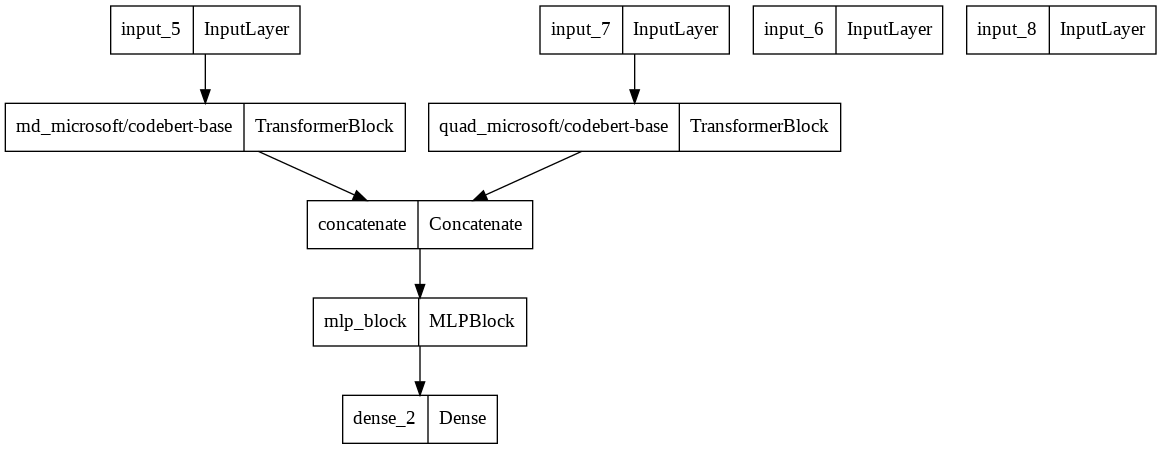

In [ ]:
# Initialize Model

with tpu_strategy.scope():
  transformer = model_class.from_pretrained(trans_name)
#  transformer = tfmodels.reinit_weights_and_bias(transformer, 5)  # Re-initialize the top 5 layers
  transformer.resize_token_embeddings(len(tokenizer))

  model = tfmodels.MDCodeRep(transformer, model_name, trans_name, trans_model)
  lr_scheduler = tfmodels.WarmupCosineDecay(base_learning_rate=params['learning_rate'],
                                            warmup_steps=warmup_steps,
                                            total_steps=total_steps)
  lr_optimizer = AdamWeightDecay(lr_scheduler,
                                 weight_decay_rate=0.01,
                                 exclude_from_weight_decay=['bias', 'LayerNorm.bias', 'LayerNorm.weight'])
  if checkpoint_metric == 'val_loss':
    metrics = ['mean_squared_error', 'mean_absolute_error']
  else:
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
  model.compile(optimizer=lr_optimizer, 
                loss=loss_function(),
                metrics=metrics,
                jit_compile=True)
  display(model.build_graph().summary())
  display(plot_model(model.build_graph()))

In [ ]:
# Initalize Neptune Metadata Tracker Callback
neptune_token = apitokens.neptune_token

run = neptune.init(project="robby700/GCode",
                    name="Google AI4Code Challenge",
                    tags=[f'{trans_model}', f'{model_objective}'],
                    api_token=neptune_token,
                    capture_hardware_metrics=False)

run['hyper_parameters'] = params
neptune_cbk = tfmodels.NeptuneCallback(run=run)

# Initalize Model Checkpoint Callback
checkpoint_filepath = f'gs://{model_objective}/checkpoints/{model_name}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               monitor=checkpoint_metric,
                                                               mode='max',
                                                               verbose=1,
                                                               save_weights_only=False,
                                                               save_best_only=True)

https://app.neptune.ai/robby700/GCode/e/GCOD-153
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
# Train Model
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    steps_per_epoch=train_steps_per_epoch, 
                    validation_steps=validation_steps_per_epoch,
                    epochs=params['epochs'],
                    callbacks=[neptune_cbk, model_checkpoint_callback])

Epoch 1/3


     6/120000 [..............................] - ETA: 7:49:53 - loss: 1.1638 - mean_squared_error: 1.4528 - mean_absolute_error: 1.1638WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0054s vs `on_train_batch_end` time: 14.9225s). Check your callbacks.


120000/120000 [==============================] - ETA: 0s - loss: 0.1281 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1281
Epoch 1: val_loss improved from -inf to 0.10941, saving model to gs://md_code_rep/checkpoints/cbert_md_code_rep


INFO:tensorflow:Assets written to: gs://md_code_rep/checkpoints/cbert_md_code_rep/assets


INFO:tensorflow:Assets written to: gs://md_code_rep/checkpoints/cbert_md_code_rep/assets


120000/120000 [==============================] - 30233s 251ms/step - loss: 0.1281 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1281 - val_loss: 0.1094 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1094
Epoch 2/3
120000/120000 [==============================] - ETA: 0s - loss: 0.0915 - mean_squared_error: 0.0240 - mean_absolute_error: 0.0915
Epoch 2: val_loss did not improve from 0.10941
120000/120000 [==============================] - 30140s 251ms/step - loss: 0.0915 - mean_squared_error: 0.0240 - mean_absolute_error: 0.0915 - val_loss: 0.1029 - val_mean_squared_error: 0.0316 - val_mean_absolute_error: 0.1029
Epoch 3/3
 10367/120000 [=>............................] - ETA: 7:11:48 - loss: 0.0834 - mean_squared_error: 0.0208 - mean_absolute_error: 0.0834

KeyboardInterrupt: ignored

In [ ]:
# Stop Neptune Run
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/robby700/GCode/e/GCOD-153


In [ ]:
# First save the model, then you should do testing below

model_save_path =  f'gs://{model_objective}/models/{model_name}'
path = Path(model_save_path)

while path.exists():
  print(f"Model name {model_name} is already taken, adding a '_latest' to the end.")
  model_save_path += '_latest'
  path = Path(model_save_path)

model.save(model_save_path)
print(f"Model has been saved at {model_save_path}")

INFO:tensorflow:Assets written to: gs://md_code_rep/models/cbert_md_code_rep/assets


INFO:tensorflow:Assets written to: gs://md_code_rep/models/cbert_md_code_rep/assets


Model has been saved at gs://md_code_rep/models/cbert_md_code_rep


### Analyze Predictions for Threshold

In [ ]:
# Double check all features have been parased and prepared correctly

for batch_features, batch_labels in train_dataset.take(1):
  print(f'Train Dataset Tensor Spec:\n{train_dataset}\n')
  print(f'Parsed Input Ids:\n{batch_features[0]}\n')
  print(f'Parsed Attention Mask:\n{batch_features[1]}\n')
  print(f'Parsed Labels:\n{batch_labels}\n')

In [ ]:
# Check predictions on a single batch
predictions = model.predict(batch_features, verbose=2)
print(f'\nPredictions with dtype {predictions.dtype}:\n{predictions}')
print(f'\nTrue Labels wtih dtype {batch_labels.dtype}:\n{batch_labels}')

In [ ]:
# Collect valid labels and run predictions for comparison, this takes a while around 20-25 minutes
valid_labels = valid_analysis.get_labels(valid_dataset)
valid_predictions = model.predict(valid_dataset, verbose=1)

In [ ]:
# Print ROC Curve and Threshold
roc_auc, best_threshold = valid_analysis.plot_roc_curve(valid_labels, valid_predictions)

In [ ]:
# Calculate and plot confusion matrix at best threshold from ROC
binary_valid_preds = np.where(valid_predictions >= best_threshold, 1, 0)

tn, fp, fn, tp = valid_analysis.confusion_matrix(valid_labels, binary_valid_preds).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)

cm, cm_perc = valid_analysis.plot_confusion_matrix(valid_labels, binary_valid_preds)
print(f'At an optimal ROC threshold of {best_threshold:.2f}. Precision is {precision:.2f} and recall is {recall:.2f}.\n')